In [265]:
from typing import Tuple
"""## mlocs - Maidenhead
toMaiden([lat, lon], level) returns a char (len = lvl*2)
toLoc(mloc) takes any string and returns topleft [lat,lon] within mloc

"""


def toLoc(maiden: str) -> Tuple[float, float]:
    """
    input: maidenhead locator of length 2 to 8
    output: [lat,lon]
    """
    if not isinstance(maiden, str):
        raise TypeError('Maidenhead locator must be a string')

    maiden = maiden.strip().upper()

    N = len(maiden)
    if not 8 >= N >= 2 and N % 2 == 0:
        raise ValueError('Maidenhead locator requires 2-8 characters, even number of characters')

    Oa = ord('A')
    lon = -180.
    lat = -90.
# %% first pair
    lon += (ord(maiden[0])-Oa)*20
    lat += (ord(maiden[1])-Oa)*10
# %% second pair
    if N >= 4:
        lon += int(maiden[2])*2
        lat += int(maiden[3])*1
# %%
    if N >= 6:
        lon += (ord(maiden[4])-Oa) * 5./60
        lat += (ord(maiden[5])-Oa) * 2.5/60
# %%
    if N >= 8:
        lon += int(maiden[6]) * 5./600
        lat += int(maiden[7]) * 2.5/600

    return lat, lon


def toMaiden(lat: float, lon: float,
             precision: int = 3) -> str:
    """Returns a maidenhead string for specified lat-lon tuple at specified level.
    """

    A = ord('A')
    a = divmod(lon+180, 20)
    b = divmod(lat+90, 10)
    astring = chr(A+int(a[0])) + chr(A+int(b[0]))
    lon = a[1] / 2.
    lat = b[1]
    i = 1
    while i < precision:
        i += 1
        a = divmod(lon, 1)
        b = divmod(lat, 1)
        if not (i % 2):
            astring += str(int(a[0])) + str(int(b[0]))
            lon = 24 * a[1]
            lat = 24 * b[1]
        else:
            astring += chr(A+int(a[0])) + chr(A+int(b[0]))
            lon = 10 * a[1]
            lat = 10 * b[1]

    if len(astring) >= 6:
        astring = astring[:4] + astring[4:6].lower() + astring[6:]

    return astring


from math import radians, cos, sin, asin, sqrt, atan2, pi

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers.

    bearing = atan2(sin(lon2-lon1)*cos(lat2), cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1))
    bearing = degrees(bearing)
    bearing = (bearing + 360) % 360
    
    return c * r, bearing

In [316]:
%pylab inline

from collections import defaultdict
import urllib.request
import numpy as np
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime, time


def get_url(band, spot_number, reporter):
    return "http://wsprnet.org/olddb?mode=html&band=%d&limit=%d&findcall=&findreporter=%s&sort=date" % (band, spot_number, reporter)


def strip_data(data):
    for i, row in enumerate(data):
        for j, el in enumerate(row):
            data[i][j] = el.strip()
    return data


def running_mean(x, N):
    x = np.array(x)
    print (x.shape)
    x = np.concatenate((x, x[0:N-1]), axis=0)
    print (x.shape)
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def extract_wspr_data(contents):    
    d_dict = defaultdict(list)
    spotter_loc_dict = {}

    for content in contents:
        for row in content.splitlines():
            row = row.decode()
            if "<tr id=\"evenrow\"><td align=left>&nbsp;" in row or "<tr id=\"oddrow\"><td align=left>&nbsp;" in row:
                row = row.replace("&nbsp", "")
                row_list = row.split(";")[1::2]
                #print (row_list)
                timestamp = row_list[0]
                callsign = row_list[1]
                frequency = float(row_list[2])
                snr = float(row_list[3])
                locator = row_list[5]
                power = float(row_list[7])
                spotter = row_list[8]
                spotter_locator = row_list[9]
                distance = float(row_list[10])

                d_dict[spotter].append((timestamp, callsign, frequency, snr, locator, power, distance))
                spotter_loc_dict[spotter] = (spotter_locator)
    
    return spotter_loc_dict, d_dict

def extract_info(d_dict):
    callsign_dict = defaultdict(int)
    coord_dict = {}
    for reporter in d_dict:
        dist_dict = {el[1]: el[6] for el in d_dict[reporter]}
        for el in d_dict[reporter]:
            call = el[1]
            locator = el[4]
            callsign_dict[call] += 1
            coord_dict[call] = toLoc(locator)
                
    return dist_dict, coord_dict, callsign_dict

def download_wspr_data(band, spot_number, reporter):
    link = get_url(band, spot_number, reporter)
    contents = urllib.request.urlopen(link).read()
    
    return contents

def most_spotted(callsign_dict):
    callsign_sorted_byspots = sorted(callsign_dict, key=callsign_dict.get, reverse=True)
    return callsign_sorted_byspots

def data_by_callsign(callsign_sorted_byspots):
    data_bycallsign_dict = {}
    for call in callsign_sorted_byspots:
        #print(call)
        data_bycallsign_dict[call] = {}
        for reporter in d_dict:
            tmp_dict = []
            for el in d_dict[reporter]:
                if call in el:
                    tmp_dict.append(el[0:1]+el[2:])
            data_bycallsign_dict[call][reporter] = tmp_dict
    return data_bycallsign_dict

def data_by_callsign_common(data_bycallsign_dict):
    common_ts_bycall = {}
    for call in data_bycallsign_dict.keys():
        if sum([1 for rep in data_bycallsign_dict[call]]) == 2:
            timeseries_list = []
            for rep in reporter_list:
                ts_tmp = [el[0] for el in data_bycallsign_dict[call][rep]]
                #ts_tmp = sorted(ts_tmp, key=lambda k: get_unixtime(k), reverse=False)
                timeseries_list.append(ts_tmp)
            common_ts = []
            for i, ts1 in enumerate(timeseries_list[0]):
                if ts1 in timeseries_list[1]:
                    j = timeseries_list[1].index(ts1)
                    common_ts.append((i,j))
            common_ts_bycall[call] = common_ts
    return common_ts_bycall
            
def get_unixtime(date_string):
    date_time_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M')
    unixtime = time.mktime(date_time_obj.timetuple())
    return unixtime


def get_snr_bycall(callsign_sorted_byspots, data_bycallsign_dict, topn=-1, plot_flag=False):
    if plot_flag:
        figure(figsize=(12,8))
    snr_dict = {}
    for call in callsign_sorted_byspots[:topn]:
        snr_dict[call] = {}
        for reporter in data_bycallsign_dict[call]:
            timeseries = data_bycallsign_dict[call][reporter]
            timeseries = sorted(timeseries, key=lambda k: timeseries[0], reverse=True)
            unixtime_list = [get_unixtime(el[0]) for el in timeseries]
            snr_list = [el[2] for el in timeseries]
            snr_dict[call][reporter] = (unixtime_list, snr_list)
            if plot_flag:
                plot(unixtime_list, snr_list, "-o", label=call+" "+reporter, alpha=0.6)
    #legend()
    if plot_flag:
        grid()
    return snr_dict


def get_deltasnr_bycall(callsign_sorted_byspots, data_bycallsign_dict, topn=-1, plot_flag=False):
    if plot_flag:
        figure(figsize=(12,8))
    deltasnr_bycall_dict = {}
    for call in callsign_sorted_byspots[:topn]:
        timeseries = common_ts_bycall[call]
        if len(timeseries) == 0:
            continue
        unixtime_list = [get_unixtime(data_bycallsign_dict[call][reporter_list[0]][el[0]][0]) for el in timeseries]
        snr_list_0 = [data_bycallsign_dict[call][reporter_list[0]][el[0]][2] for el in timeseries]
        snr_list_1 = [data_bycallsign_dict[call][reporter_list[1]][el[1]][2] for el in timeseries]

        unixtime_list, snr_list_0, snr_list_1 = (list(t) for t in zip(*sorted(zip(unixtime_list, snr_list_0, snr_list_1), key=lambda k: k[0], reverse=False)))
        deltasnr_list = [snr_1-snr_0-rx_offset for snr_0,snr_1 in zip(snr_list_0, snr_list_1)]

        deltasnr_bycall_dict[call] = (unixtime_list, deltasnr_list)
        if plot_flag:
            plot(unixtime_list, deltasnr_list, "-o", label=call+" "+reporter_list[0])

    if plot_flag:
        grid()
        
    return deltasnr_bycall_dict

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sin', 'sqrt', 'radians', 'cos', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [317]:
################################################
# IMPORTANT IN ORDER TO HAVE MEANINGFUL RESULTS!
rx_offset = 3   # rx sensitivity difference (db) 
                # between two receivers (should
                # be done by connecting both rx
                # to the same antenna)
###############################################

band = 20
spot_number = 3500
reporter_list =  ["IS0KYB", "IS0KYB1"]
reporter_loc = "JM49jn"
contents = []
for reporter in reporter_list:
    tmp = download_wspr_data(band, spot_number, reporter)
    contents.append(tmp)
spotter_loc_dict, d_dict= extract_wspr_data(contents)
dist_dict, coord_dict, callsign_dict = extract_info(d_dict)

In [318]:
# get the most spotted stations and their occurrences

callsign_sorted_byspots = most_spotted(callsign_dict)
data_bycallsign_dict = data_by_callsign(callsign_sorted_byspots)

In [319]:
# create a dictionary of sorted SNR timeseries with [call] and [reporter] as keys

snr_dict = get_snr_bycall(callsign_sorted_byspots, data_bycallsign_dict, topn=1, plot_flag=False)

In [320]:
# compute the common parts (wrt reporters) of timeseries (return timestamps for both reporters)
common_ts_bycall = data_by_callsign_common(data_bycallsign_dict)

In [321]:
# create a dictionary of sorted DELTA SNR timeseries with [call] as key

deltasnr_dict = get_deltasnr_bycall(callsign_sorted_byspots, data_bycallsign_dict, topn=-1, plot_flag=False)

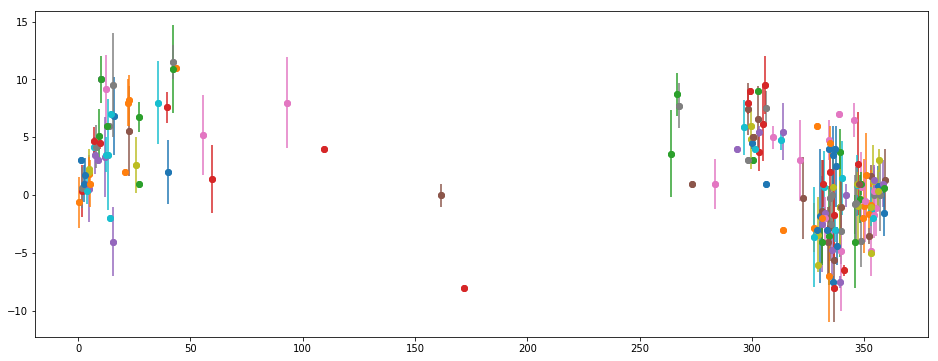

In [322]:
figure(figsize=(16,6))
for call in deltasnr_dict:
    deltasnr_list = deltasnr_dict[call]
    az = haversine(*toLoc(reporter_loc), *coord_dict[call] )
    if az[0]>16000:
        continue
    #scatter([az[1] for _ in deltasnr_list[0]], deltasnr_list[1])
    scatter(az[1], np.mean(deltasnr_list[1]))
    errorbar(az[1], np.mean(deltasnr_list[1]), yerr=np.std(deltasnr_list[1]), fmt='o')
    

/usr/lib/python3/dist-packages/matplotlib/projections/polar.py:162: RuntimeWarning: invalid value encountered in less
  theta = np.where(y < 0, 2 * np.pi - theta, theta)


(-10, 30)

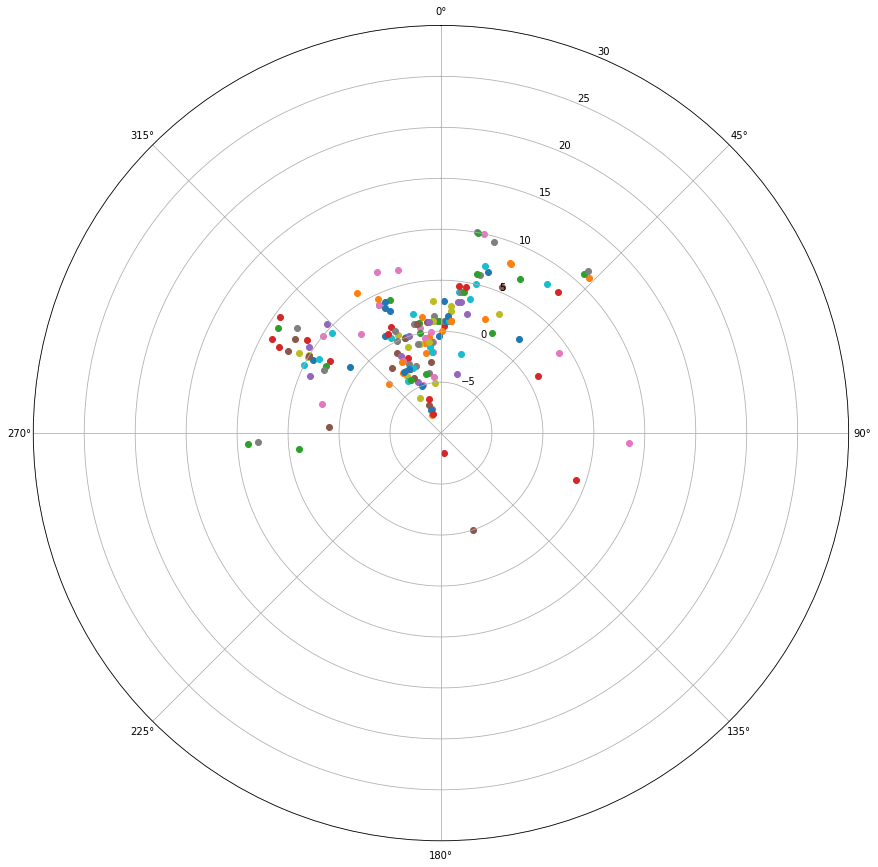

In [323]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
for call in deltasnr_dict:
    deltasnr_list = deltasnr_dict[call]
    az = haversine(*toLoc(reporter_loc), *coord_dict[call] )
    if az[0]>16000:
        continue
    #scatter([az[1] for _ in deltasnr_list[0]], deltasnr_list[1])
    ax.scatter(az[1]/360.*6.28, np.median(deltasnr_list[1]))
    #ax.errorbar(az[1]/360.*6.28, np.median(deltasnr_list[1]), yerr=np.std(deltasnr_list[1]), fmt='o')
ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,30)

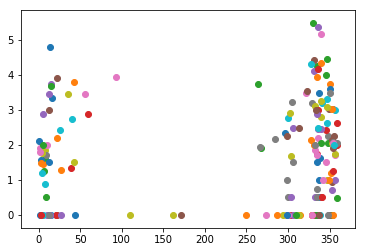

In [302]:
for call in deltasnr_dict:
    deltasnr_list = deltasnr_dict[call]
    az = haversine(*toLoc(reporter_loc), *coord_dict[call] )
    #scatter([az[1] for _ in deltasnr_list[0]], deltasnr_list[1])
    scatter(az[1], np.std(deltasnr_list[1]))


In [277]:
len(deltasnr_list)
#len([az[1] for _ in deltasnr_list[0]])

2

In [272]:
haversine(*toLoc(reporter_loc), *coord_dict["G0CCL"] )

(1557.500142514118, 337.5731145941293)

In [249]:
coord_dict["G0CCL"] 

(52.208333333333336, 0.08333333333333333)

In [251]:
toLoc(reporter_loc)

(39.541666666666664, 8.75)

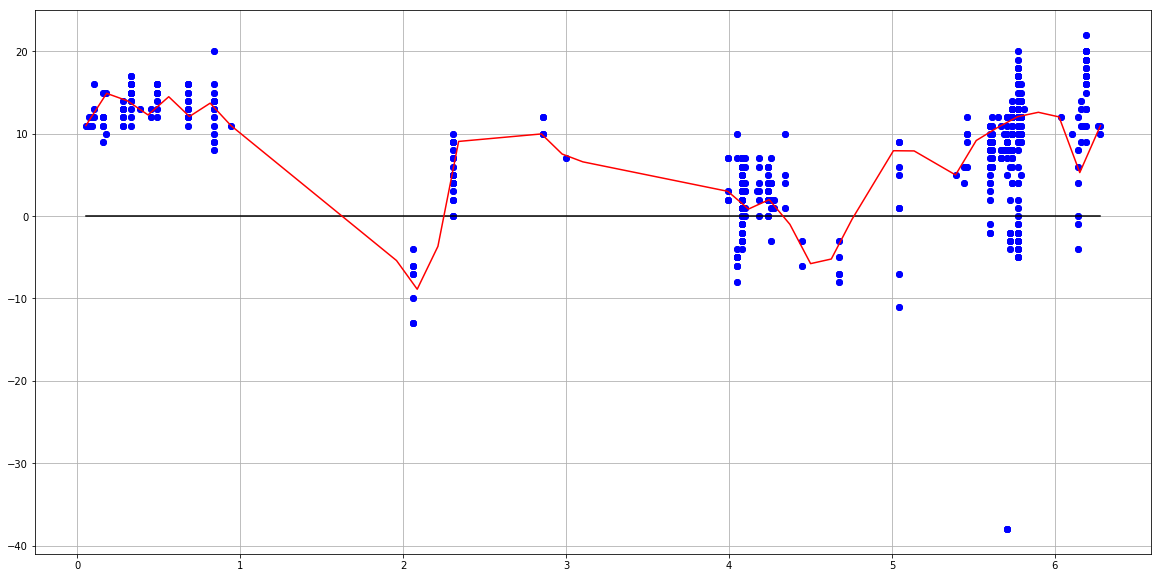

In [11]:
# Here we convert degrees to radians and perform a rough 1D interpolation 

az_rad_list = az_list[:]
for i,v in enumerate(az_list):
    az_rad_list[i] = v/360.*6.28 + 0.0000001*(2*rand()-1.)

angles, gains = zip(*sorted(zip(az_rad_list, snr_list)))
x = np.array(angles)
y = np.array(gains)

x0 = np.linspace(np.min(x),np.max(x))
y0 = np.zeros(x0.shape)

f = interpolate.interp1d(x, y, kind="linear")
figure(figsize=(20,10))
plot(x, y, 'bo', label = 'Original')
plot(x0, y0, 'k', label = 'Zero')
plot(x0, f(x0), 'r', label = 'Interpolated')
grid()
#xlim(0,6.28)
#ylim(-30,30)

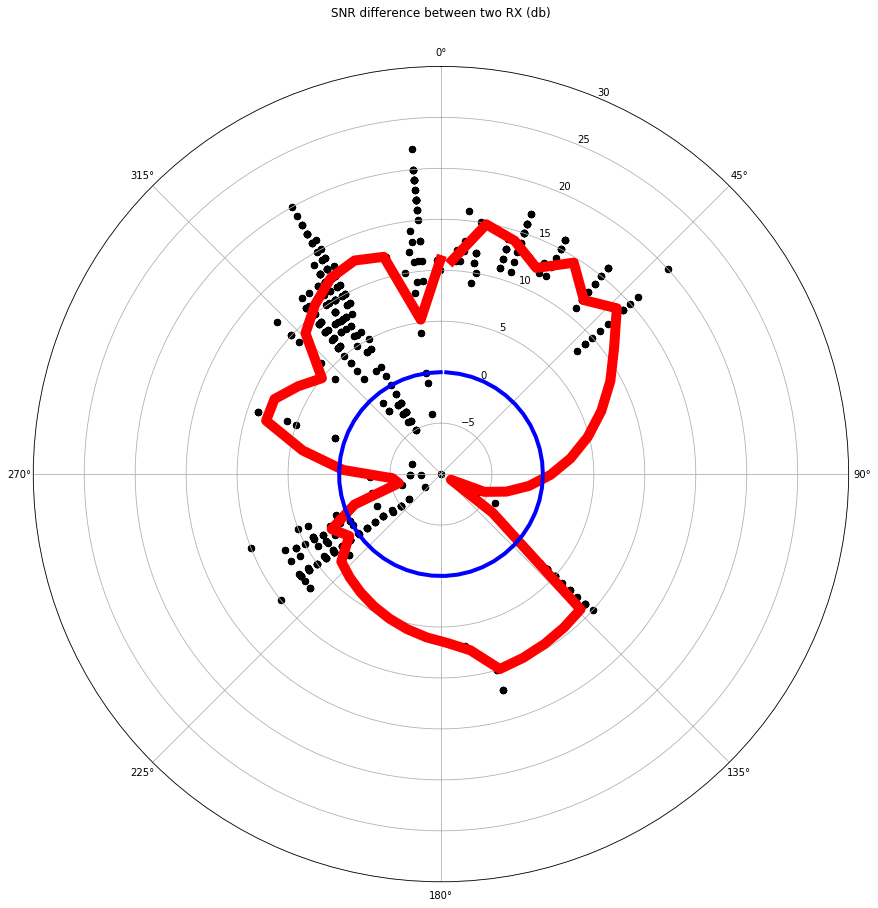

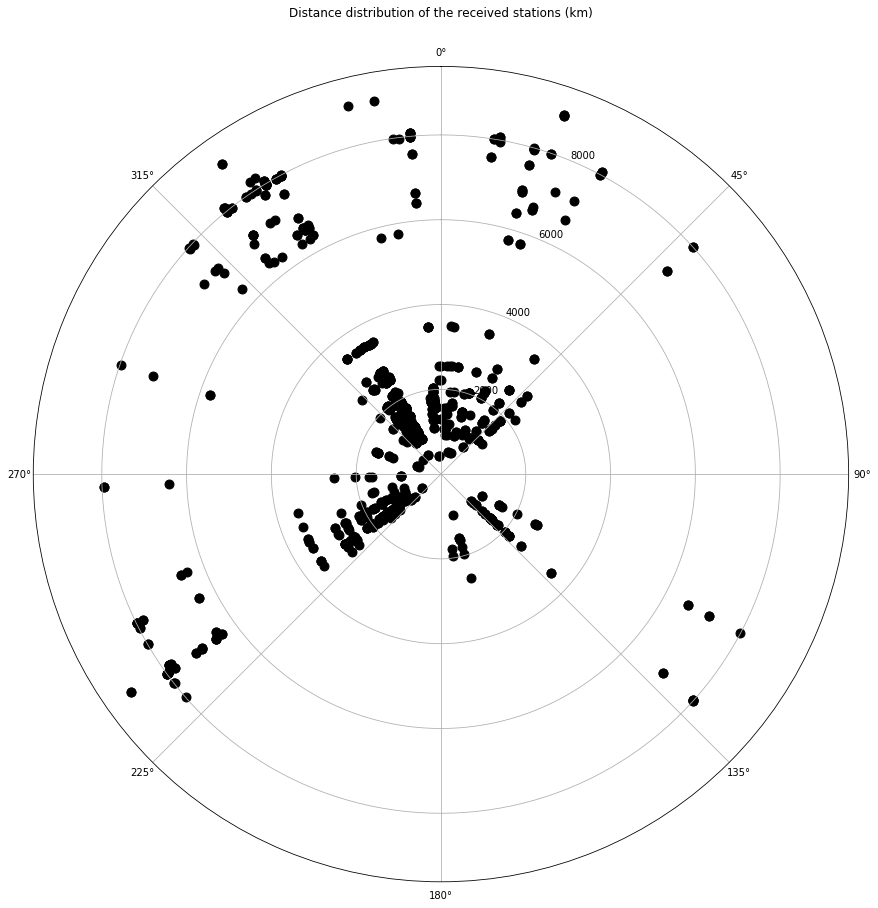

In [12]:
# Now let's finally plot the polar graph with the real SNR deltas and their interpolation
# Moreover, we plot the angular distance distribution of the spots

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
c = ax.plot(x0, f(x0), c='r', linewidth=10)
c0 = ax.plot(x0, y0, c='b', linewidth=4)
c2 = ax.scatter(x, y, c='k', s=40)

ax.set_title("SNR difference between two RX (db)", va='bottom')

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,30)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
ax.set_title("Distance distribution of the received stations (km)", va='bottom')


c2 = ax.scatter(x, dist_list, c='k', s=80)

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
